# Customer Churn Prediction

The goal of this project is to predict the loss of customers who stop using a company's products or services over a specific period (churn) based on behavior and history.

# Load and Inspect

## Importing necessary libraries

In [1455]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from itertools import product
import joblib

%matplotlib inline

We will configure pandas to allow us to see all the columns when we are printing the output

In [1456]:
pd.set_option('display.max_columns', None)

## Importing the dataset

In [1457]:
dataset_path = kagglehub.dataset_download("blastchar/telco-customer-churn")
print("Path to dataset:", dataset_path)

Path to dataset: /Users/shashanks/.cache/kagglehub/datasets/blastchar/telco-customer-churn/versions/1


Before importing, it would be beneficial to include a custom missing value representations to target cases where ' ', 'NA', etc. are used to represent null values.

In [1458]:
custom_missing_values = ["", " ", "NA", "N/A", "na", "n/a", "?", "None", "NULL", "null", "NaN", "nan"]

In [1459]:
df = pd.read_csv(f"{dataset_path}/WA_Fn-UseC_-Telco-Customer-Churn.csv", na_values=custom_missing_values)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [1460]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [1461]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


## Data Cleaning

In [1462]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Naming standardization

Let us first ensure standardization across the columns as some are written in lower camel case, upper camel case, and lowercase.

In [1463]:
rename_dict = { "customerID" : "CustomerId",
                "gender" : "Gender", 
                "tenure" : "Tenure",
                "StreamingTV" : "StreamingTv"
                }

In [1464]:
df.rename(columns=rename_dict, inplace=True)
df.head()

,CustomerId,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTv,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Handling Missing Values

Let us check for any missing values as it can introduce bias and have a significant effect on the conclusions that can be drawn from our dataset.

In [1465]:
df.isnull().sum()

CustomerId           0
Gender               0
SeniorCitizen        0
Partner              0
Dependents           0
Tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTv          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

We can see that we have 11 null values in our `TotalCharges` column

In [1466]:
df.loc[:, ["TotalCharges"]].describe()

,TotalCharges
count,7032.000000
mean,2283.300441
std,2266.771362
min,18.800000
25%,401.450000
50%,1397.475000
75%,3794.737500
max,8684.800000


We can see from the numerical summaries table above, that:
- As the mean > median (50%), the distribution of the `TotalCharges` column will be right-skewed
- As the standard deviation (std) ≈ mean, the data spans a broad range and there might be possible outliers
- As the max is more than double the 75% value, it suggests our data is right-skewed with possible outliers. This is similar to the conclusion we made in the previous 2 points as well

We can confirm the above statements by visualizing the distribution of the column.

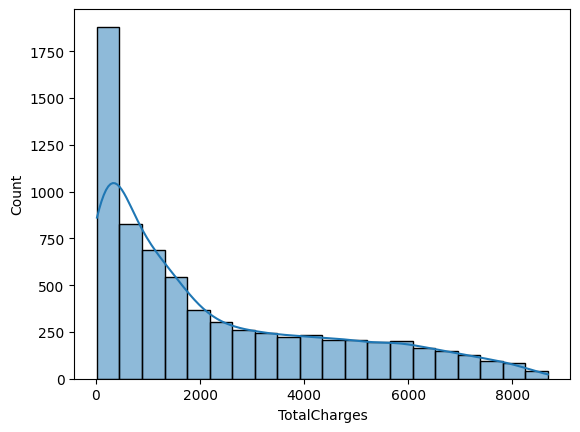

In [1467]:
sns.histplot(df.loc[:, "TotalCharges"], kde=True, bins=20)
plt.show()

We can see that the data is positively skewed as we have a long right tail. This indicates that our customers likely may have had short tenures or low monthly charges.

This confirms what we have initially assumed from the numerical summaries table, as such we cannot proceed with mean imputation as the mean will be pulled up by the high-end outliers and we could end up overestimating missing values. Therefore, we will use the median imputation as the median is more representative of the "typical" value and is robust to outliers.

In [1468]:
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

In [1469]:
df.isnull().sum()

CustomerId          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTv         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

### Correcting Data Types

In [1470]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CustomerId        7043 non-null   object 
 1   Gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   Tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTv       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [1471]:
df.head()

,CustomerId,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTv,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Exploratory Data Analysis (EDA)

Let us first check our target distribution to see if churn is balanced

In [1472]:
df['Churn'].value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [1473]:
df["Churn"].value_counts(normalize=True)

Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

We can see that our target variable is imbalanced

Now let's look at the numeric features

In [1474]:
df.describe()

,SeniorCitizen,Tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


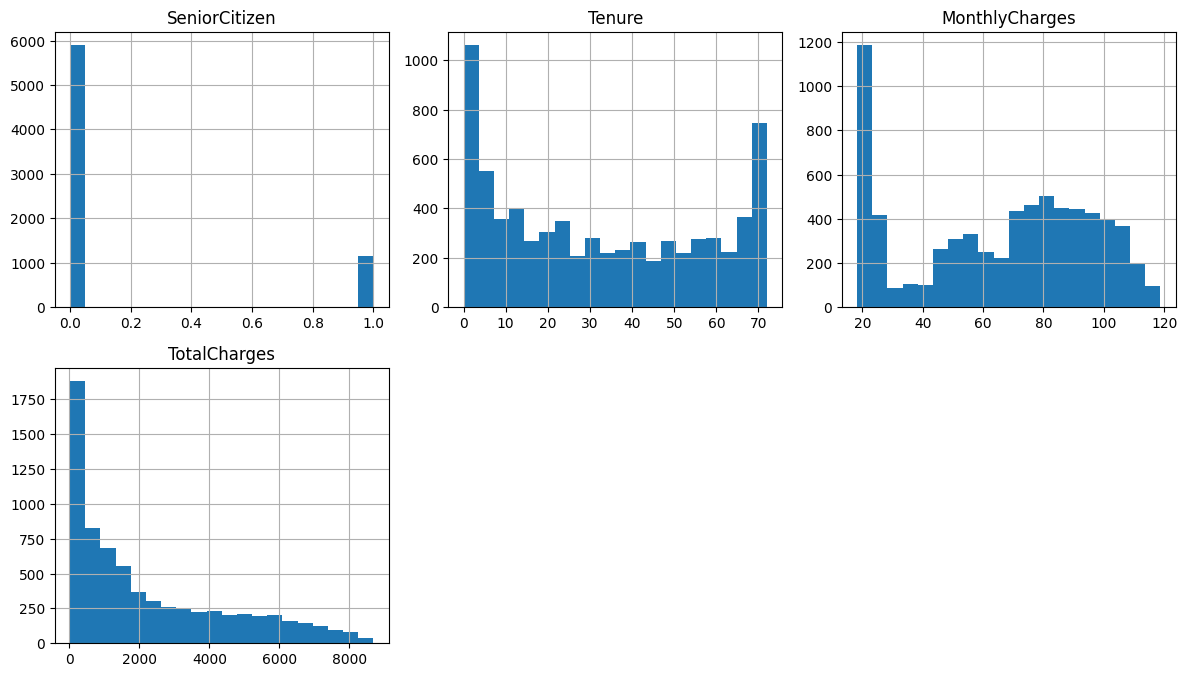

In [1475]:
df.hist(figsize=(12, 10), bins=20, layout=(3, 3))
plt.tight_layout()
plt.show()

Let us break this down one feature at a time.

- `Tenure` is bimodal, indicating that customers might either leave early or stay for a long time
- `MonthlyCharges` has a slight left skew as there's a longer tail towards the lower values, but not too extreme. However we can see that a majority of customers are paying the minimum (probably to afford the basic services only)
- `TotalCharges` has a heavy pile-up near 0 with a long tail stretching right. As mentioned above, this indicates that it is right-skewed. This is likely because new customers (those with low tenure) naturally have low total charges

In [1476]:
df[["Tenure", "MonthlyCharges", "TotalCharges"]].skew()

Tenure            0.239540
MonthlyCharges   -0.220524
TotalCharges      0.963789
dtype: float64

We can confirm our observations using the skew value of each column above. Tenure and MonthlyCharges are slightly right and left skewed respectively. Meanwhile, we can see a significant positive skewness in TotalCharges.

Now let's look at our categorical features

In [1477]:
# Converting SeniorCitizen to categorical for better interpretability
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

In [1478]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols.remove('CustomerId') # CustomerId is not a feature, it's an identifier
cat_cols.remove('Churn') # Churn is the target variable
cat_cols

['Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTv',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

Let's convert our Churn column to an int to be able to calculate the churn rates of each individual column

In [1479]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

In [1480]:
for col in cat_cols:
    print(df.groupby(col)["Churn"].mean(), "\n")

Gender
Female    0.269209
Male      0.261603
Name: Churn, dtype: float64 

SeniorCitizen
No     0.236062
Yes    0.416813
Name: Churn, dtype: float64 

Partner
No     0.329580
Yes    0.196649
Name: Churn, dtype: float64 

Dependents
No     0.312791
Yes    0.154502
Name: Churn, dtype: float64 

PhoneService
No     0.249267
Yes    0.267096
Name: Churn, dtype: float64 

MultipleLines
No                  0.250442
No phone service    0.249267
Yes                 0.286099
Name: Churn, dtype: float64 

InternetService
DSL            0.189591
Fiber optic    0.418928
No             0.074050
Name: Churn, dtype: float64 

OnlineSecurity
No                     0.417667
No internet service    0.074050
Yes                    0.146112
Name: Churn, dtype: float64 

OnlineBackup
No                     0.399288
No internet service    0.074050
Yes                    0.215315
Name: Churn, dtype: float64 

DeviceProtection
No                     0.391276
No internet service    0.074050
Yes                  

We can see that:

- `Gender` does have seem to have an effect on churn
- Being a `SeniorCitizien` seems to result in a higher churn
- Not having a `Partner` seems to result in a higher churn
- Not having `Dependents` seems to result in a higher churn
- `PhoneService` does not seem to have an effect on churn
- `MultipleLines` also does not seem to have an effect on churn
- Having a 'Fiber optic' `InternetService` seems to result in higher churn. This could be due to poor quality with the fiber optic connection.
- Not providing `OnlineSecurity` seems to result in higher churn. This is probably due to security being a major factor for customers.
- `OnlineBackup` seems to result in a slightly higher churn. This could be because customers are looking for quantity of features with their internet service.
- `DeviceProtection` is similar to `OnlineBackup`
- Not providing `TechSupport` seems to result in high churn. This is probably because there is no timely resolution of customer issues without tech support.
- `StreamingTv` and `StreamingMovies` don't seem to have an effect on churn.
- A 'Month-to-month' `Contract` seems to have a higher churn. This might be because customers are able to re-evaluate at the start of each month. This might also be because customers would opt for month-to-month if they are planning on using it for short-term needs or are testing the service.
- `PaperlessBilling` shows a higher churn rate. This could be because terminating the service would prove easier and less time consuming than getting rid of bills and starting fresh.
- 'Electronic check' `PaymentMethod` shows a significantly higher churn rate compared to other payment methods.

Now that we've seen the distribution and feature-wise churn rate, we can look into correlations between the numeric features

In [1481]:
corr = df.corr(numeric_only=True)
corr

,Tenure,MonthlyCharges,TotalCharges,Churn
Tenure,1.000000,0.247900,0.825464,-0.352229
MonthlyCharges,0.247900,1.000000,0.650864,0.193356
TotalCharges,0.825464,0.650864,1.000000,-0.199037
Churn,-0.352229,0.193356,-0.199037,1.000000


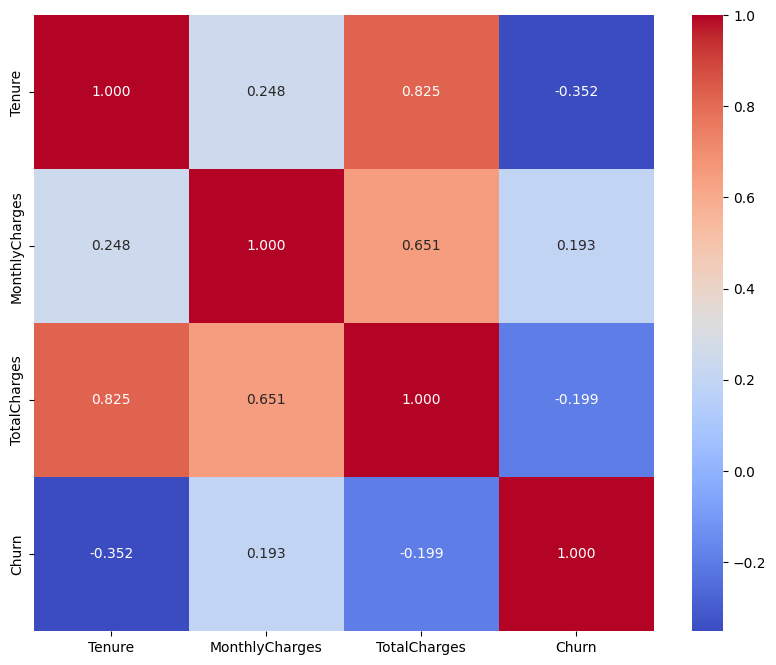

In [1482]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".3f", cmap='coolwarm')
plt.show()

We can see that there is no strong correlations between the numeric features and churn.

Tenure, as one would suspect, has a negative correlation with churn. This indicates that the shorter a customer's tenure, the more likely they are to stop doing business.

We can see that there is a strong correlation amongst the numeric features though:
- `Tenure` and `TotalCharges` have a strong positive correlation - the longer one does business, the more their total charges
- `MonthlyCharges` and `TotalCharges` also have a positive correlation - the higher one's monthly costs, the more their total charges

## Visualizing key relationships

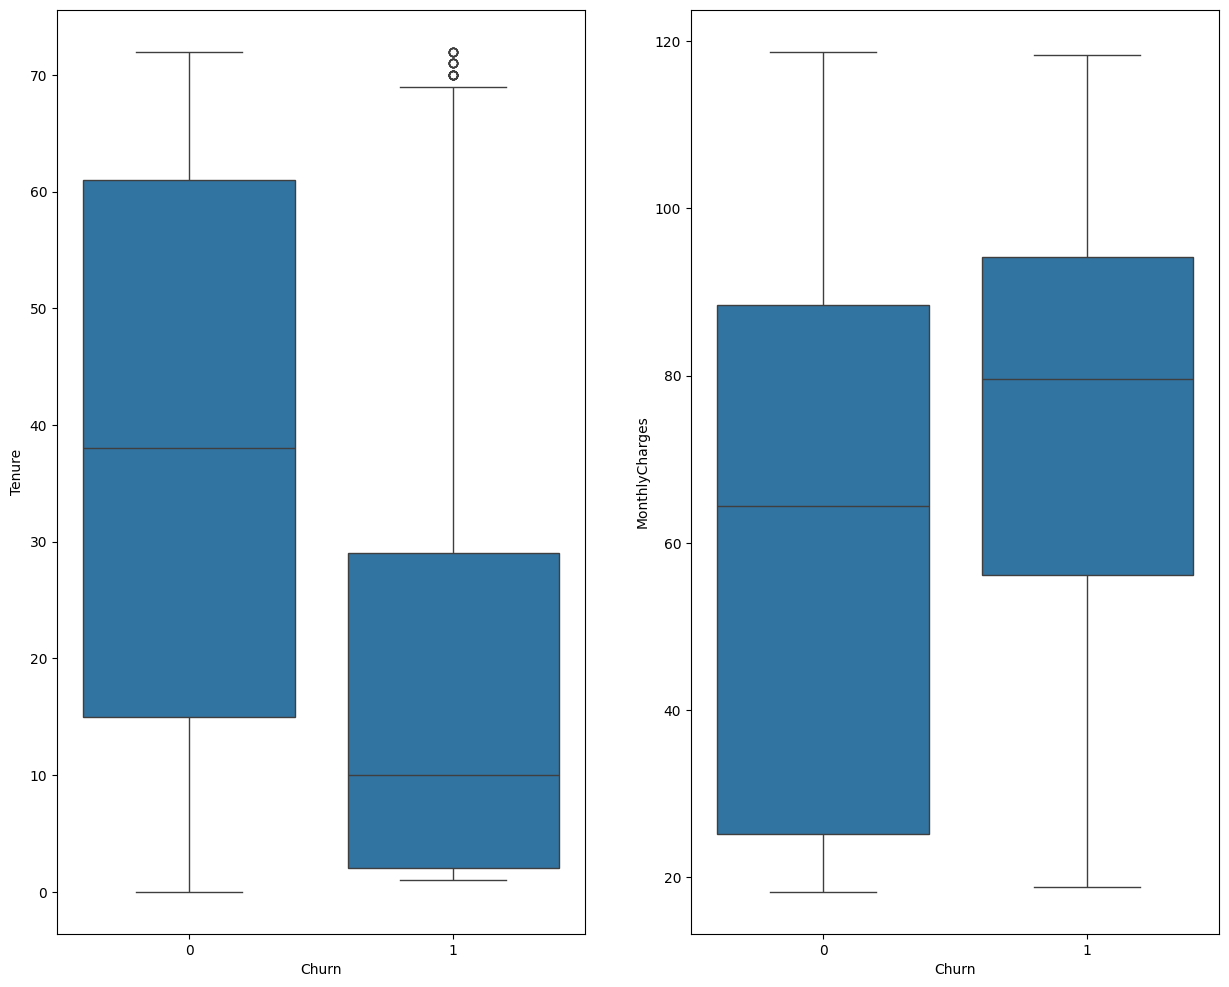

In [1483]:
fig, axes = plt.subplots(1, 2, figsize=(15, 12))
sns.boxplot(x='Churn', y='Tenure', data=df, ax=axes[0])
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, ax=axes[1])
plt.show()

We can see the following about churned customers from the boxplots above:
- They tend to have lower tenure
- They tend to have higher monthly charges

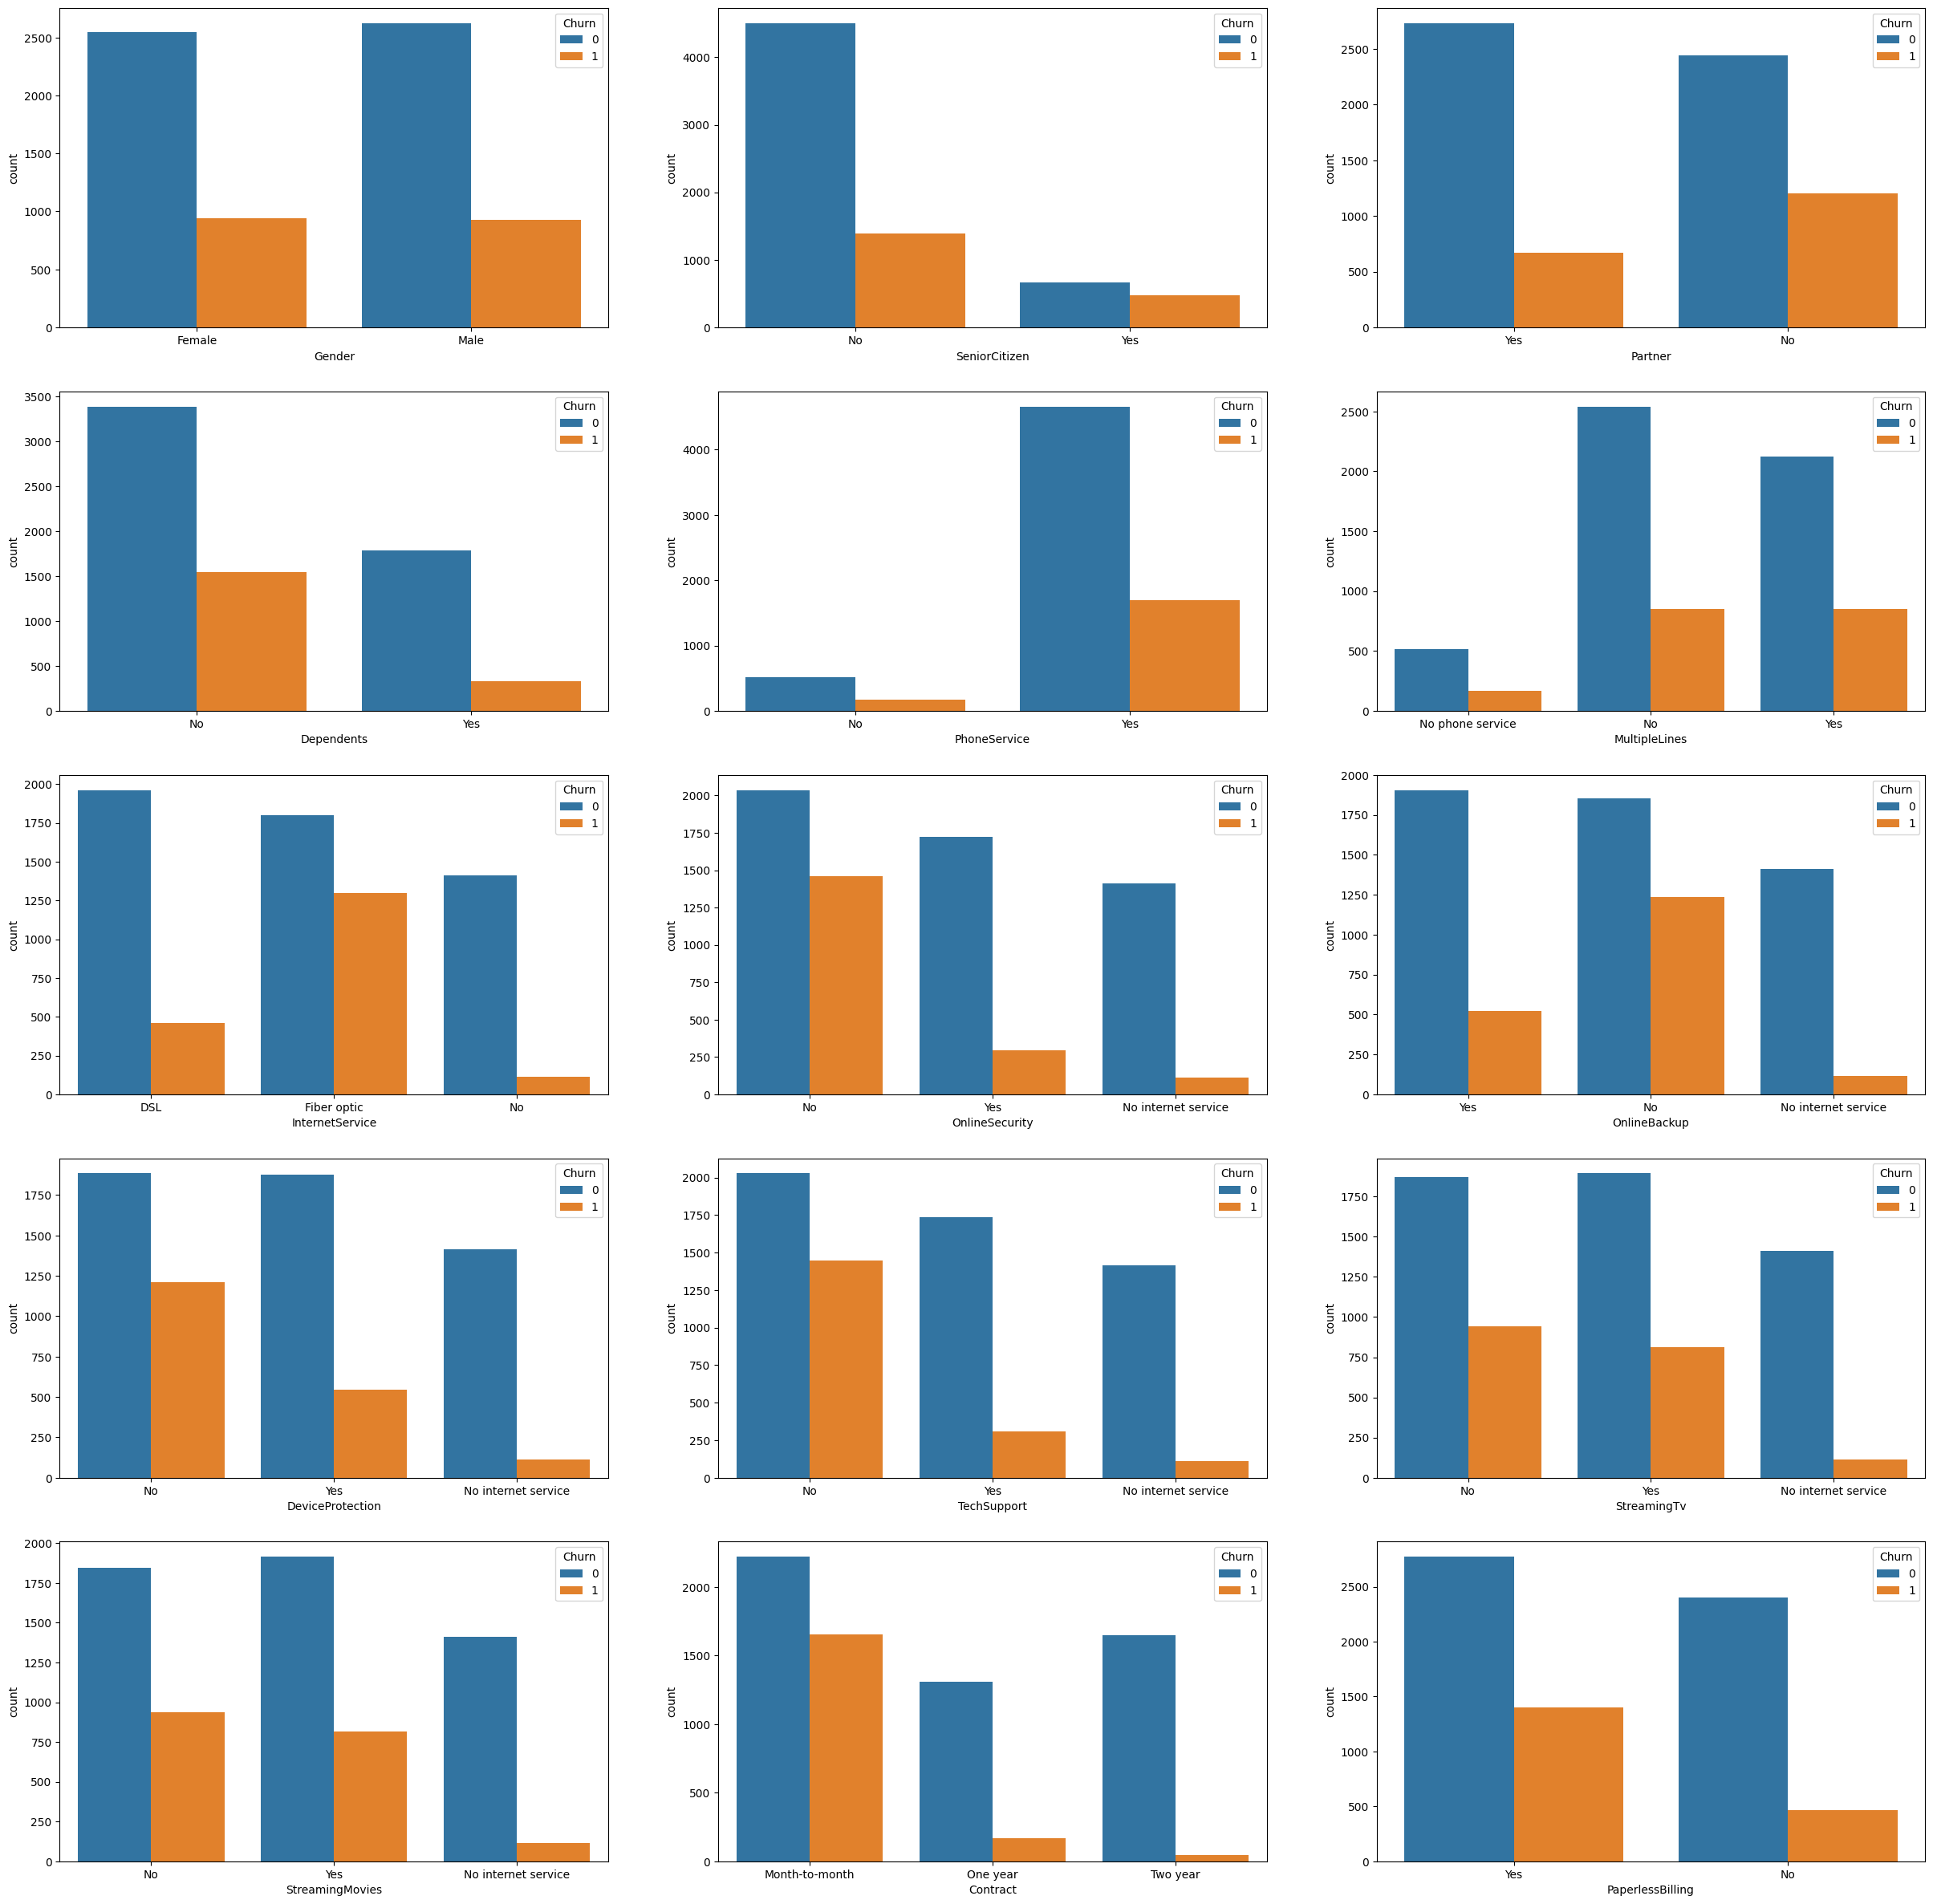

In [1484]:
fig, axes = plt.subplots(5, 3, figsize=(30, 30))

for r in range(5):
    for c in range(3):
        i = r * 3 + c
        if i < len(cat_cols):
            col = cat_cols[i]
            sns.countplot(x=col, hue='Churn', data=df, ax=axes[r, c])
        else:
            axes[r, c].axis('off')
plt.show()

By looking at the bar plots, we can update our assumptions regarding the following categorical variables (I will bold the changes to our previous assumptions):

- **Not** being a `SeniorCitizen` results in a higher churn. Our previous assumption was based on much lower data for senior citizens.
- Not having a `Partner` seems to result in a **slightly** higher churn
- We previously thought `PhoneService` did have an effect on churn, **however we can see that a significant portion of those who opted for `PhoneService` ended up stopping business -- this could indicate that they were not satisfied with the service provided.**

Let's verify that any changes we made did not affect any of the missing values before we move onto the next step

In [1485]:
df.isnull().sum()

CustomerId          0
Gender              0
SeniorCitizen       0
Partner             0
Dependents          0
Tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTv         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Feature Engineering

Now let's prepare our data for modelling

## Drop unnecessary columns

In [1486]:
df.drop(columns=['CustomerId'], inplace=True) # We can get rid of customerID as it is not a feature, just an identifier
df.columns

Index(['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'Tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTv',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Scaling numeric values

As our numeric values can lie in different ranges, we need to scale them to be between 0-1 to appropriately define the impact on churn that the feature has

In [1487]:
numerical_cols = ['Tenure', 'MonthlyCharges', 'TotalCharges'] # We only want to scale these numerical columns

## Encoding categorical variables

Since we cannot feed text directly to our ML models, we will convert them into numeric values.

In [1488]:
cat_cols

['Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTv',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [1489]:
# Get unique values for each categorical column
for col in cat_cols:
    unique = df[col].unique()
    print(f"{col}: {list(unique)}")

Gender: ['Female', 'Male']
SeniorCitizen: ['No', 'Yes']
Partner: ['Yes', 'No']
Dependents: ['No', 'Yes']
PhoneService: ['No', 'Yes']
MultipleLines: ['No phone service', 'No', 'Yes']
InternetService: ['DSL', 'Fiber optic', 'No']
OnlineSecurity: ['No', 'Yes', 'No internet service']
OnlineBackup: ['Yes', 'No', 'No internet service']
DeviceProtection: ['No', 'Yes', 'No internet service']
TechSupport: ['No', 'Yes', 'No internet service']
StreamingTv: ['No', 'Yes', 'No internet service']
StreamingMovies: ['No', 'Yes', 'No internet service']
Contract: ['Month-to-month', 'One year', 'Two year']
PaperlessBilling: ['Yes', 'No']
PaymentMethod: ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']


We can convert our binary columns: `Gender`, `Partner`, `Dependents`, `PhoneService`, `PaperlessBilling`, etc.

In [1490]:
ordinal_cols = ['Gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'] # These will be ordinal encoded in our preprocessor

We can one-hot encode the rest of the categorical columns as there is no true numeric order.

In [1491]:
ohe_cols = [col for col in cat_cols if col not in ordinal_cols] # These will be one-hot encoded
ohe_cols

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTv',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

For the columns that have a 'No internet service' option. We can also introduce another column `HasInternet`. This would help the model in understanding that some features do not need to be looked. This further reduces the number of features as well.

In [1492]:
# First we will create a new column `HasInternet` to indicate if the customer has internet service or not.
df['HasInternet'] = df['InternetService'].apply(lambda x: 0 if x == 'No' else 1)

In [1493]:
df.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTv,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,HasInternet
0,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,1
1,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0,1
2,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1,1
3,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1
4,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1,1


# Train-test Split

We'll split our data into training and testing data now

In [1494]:
X = df.drop(columns=['Churn'], axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [1495]:
X_train.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTv,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,HasInternet
3738,Male,No,No,No,35,No,No phone service,DSL,No,No,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,49.20,1701.65,1
3151,Male,No,Yes,Yes,15,Yes,No,Fiber optic,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,75.10,1151.55,1
4860,Male,No,Yes,Yes,13,No,No phone service,DSL,Yes,Yes,No,Yes,No,No,Two year,No,Mailed check,40.55,590.35,1
3867,Female,No,Yes,No,26,Yes,No,DSL,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),73.50,1905.70,1
3810,Male,No,Yes,Yes,1,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Electronic check,44.55,44.55,1


In [1496]:
X_test.head()

,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTv,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,HasInternet
437,Male,No,Yes,Yes,72,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),114.05,8468.20,1
2280,Female,Yes,No,No,8,Yes,Yes,Fiber optic,No,No,No,Yes,Yes,Yes,Month-to-month,Yes,Credit card (automatic),100.15,908.55,1
2235,Female,No,Yes,Yes,41,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,No,One year,Yes,Credit card (automatic),78.35,3211.20,1
4460,Male,No,Yes,No,18,Yes,No,Fiber optic,No,No,Yes,Yes,No,No,Month-to-month,No,Electronic check,78.20,1468.75,1
3761,Female,No,Yes,No,72,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,Yes,Credit card (automatic),82.65,5919.35,1


In [1497]:
y_train.head()

3738    0
3151    0
4860    0
3867    0
3810    0
Name: Churn, dtype: int64

In [1498]:
y_test.head()

437     0
2280    0
2235    0
4460    0
3761    0
Name: Churn, dtype: int64

# Model Selection and Baseline

## Pipeline setup

As we saw during EDA, our numerical variables do not have the same distribution nor do they follow a normal distribution. As such, we will be using the MinMaxScaler to preserve their distributions

In [1525]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('ord_encode', OrdinalEncoder(handle_unknown='error'), ordinal_cols), # We will default unknown values to 0 for ordinal encoding -- note that this might bias the model
        ('ohe_encode', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), ohe_cols)
    ],
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [1526]:
def train_model(model, param_grid):
    """
    We created this function to be able to train and evaluate different models easily.
    """
    
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model()) # This will be our starting model as it is simple and interpretable
    ])

    grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, error_score='raise')
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    print(f"Best parameters: {grid_search.best_params_}")
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob)}")

    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    f1_scores = 2 * (precision * recall) / (precision + recall)
    best_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Best threshold for F1 score: {best_threshold}")

    return best_model, best_threshold, np.max(f1_scores)

In [1527]:
best_lr_model, best_threshold, best_f1_score = train_model(LogisticRegression, {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['liblinear'],
})

Best parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1035
           1       0.65      0.56      0.60       374

    accuracy                           0.80      1409
   macro avg       0.75      0.72      0.73      1409
weighted avg       0.80      0.80      0.80      1409

ROC AUC Score: 0.840915549355447
Best threshold for F1 score: 0.37939503802306035


We'll add this to a dictionary to enable us to compare the different models that we'll test on our data

In [1528]:
model_dict = {}

In [1529]:
model_dict['LogisticRegression'] = best_f1_score

Now let's try to test out other models.

## Decision Tree

In [1530]:
best_dt_model, best_threshold, best_f1_score = train_model(DecisionTreeClassifier, {
    'classifier__max_depth': [None, 5, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
})

Best parameters: {'classifier__criterion': 'entropy', 'classifier__max_depth': 5, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 5}
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.65      0.47      0.55       374

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.71      1409
weighted avg       0.78      0.79      0.78      1409

ROC AUC Score: 0.8281123252990261
Best threshold for F1 score: 0.4932821497120921


In [1531]:
model_dict['DecisionTreeClassifier'] = best_f1_score

## Random Forest

In [1533]:
best_rf_model, best_threshold, best_f1_score = train_model(RandomForestClassifier, {
    'classifier__n_estimators': [100, 200, 500],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'classifier__bootstrap': [True, False]
})

Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 10, 'classifier__max_features': 'log2', 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 500}
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.80      1409

ROC AUC Score: 0.8444948203260223
Best threshold for F1 score: 0.2983106422717006


In [1534]:
model_dict['RandomForestClassifier'] = best_f1_score

## XGBoost

In [1535]:
best_xgb_model, best_threshold, best_f1_score = train_model(XGBClassifier, {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 1.0],
    'classifier__colsample_bytree': [0.8, 1.0],
    'classifier__gamma': [0, 1, 5],
    'classifier__min_child_weight': [1, 3, 5]
})

Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 5, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 300, 'classifier__subsample': 0.8}
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.66      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

ROC AUC Score: 0.8464878968715286
Best threshold for F1 score: 0.32042497396469116


In [1536]:
model_dict['XGBClassifier'] = best_f1_score

In [1540]:
model_results = pd.DataFrame(model_dict.items(), columns=['Model', 'f1_score'])
model_results.sort_values(by='f1_score', ascending=False, inplace=True)
model_results.reset_index(drop=True, inplace=True)
model_results

,Model,f1_score
0,RandomForestClassifier,0.639397
1,XGBClassifier,0.638581
2,LogisticRegression,0.620525
3,DecisionTreeClassifier,0.614987


We'll now save our best model for future use.

In [1551]:
switch = {
    'LogisticRegression': best_lr_model,
    'DecisionTreeClassifier': best_dt_model,
    'RandomForestClassifier': best_rf_model,
    'XGBClassifier': best_xgb_model
}

joblib.dump(switch[model_results.loc[0, 'Model']], 'churn_prediction_model.joblib')

['churn_prediction_model.joblib']

# Testing on random data

We'll now create some random data to see whether our model works as expected.

In [1559]:
# Let's first create some random data -- keep in mind this is random and might not represent "real-world" scenarios
data = {
    'CustomerId': ['0001', '0002', '0003', '0004', '0005'],
    'Gender': ['Female', 'Male', 'Male', 'Female', 'Female'],
    'SeniorCitizen': ['No', 'Yes', 'No', 'No', 'Yes'],
    'Partner': ['Yes', 'No', 'No', 'Yes', 'No'],
    'Dependents': ['No', 'No', 'Yes', 'Yes', 'No'],
    'Tenure': [1, 34, 2, 45, 5],
    'PhoneService': ['No', 'Yes', 'Yes', 'Yes', 'No'],
    'MultipleLines': ['No phone service', 'Yes', 'No', 'Yes', 'No phone service'],
    'InternetService': ['DSL', 'Fiber optic', 'Fiber optic', 'DSL', 'DSL'],
    'OnlineSecurity': ['No', 'Yes', 'No', 'Yes', 'No'],
    'OnlineBackup': ['Yes', 'No', 'Yes', 'No', 'Yes'],
    'DeviceProtection': ['No', 'Yes', 'No', 'Yes', 'No'],
    'TechSupport': ['No', 'No', 'Yes', 'No', 'Yes'],
    'StreamingTv': ['No', 'Yes', 'No', 'Yes', 'No'],
    'StreamingMovies': ['No', 'Yes', 'No', 'Yes', 'No'],
    'Contract': ['Month-to-month', 'One year', 'Month-to-month', 'Two year', 'Month-to-month'],
    'PaperlessBilling': ['Yes', 'No', 'Yes', 'No', 'Yes'],
    'PaymentMethod': ['Electronic check', 'Mailed check', 'Electronic check', 'Bank transfer', 'Credit card'],
    'MonthlyCharges': [29.85, 56.95, 53.85, 42.30, 70.70],
    'TotalCharges': [29.85, 1889.50, 108.15, 1840.75, 151.65],
    'Churn': ['No', 'No', 'Yes', 'No', 'Yes']
}

random_df = pd.DataFrame(data)
random_df.head()

,CustomerId,Gender,SeniorCitizen,Partner,Dependents,Tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTv,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0001,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,0002,Male,Yes,No,No,34,Yes,Yes,Fiber optic,Yes,No,Yes,No,Yes,Yes,One year,No,Mailed check,56.95,1889.50,No
2,0003,Male,No,No,Yes,2,Yes,No,Fiber optic,No,Yes,No,Yes,No,No,Month-to-month,Yes,Electronic check,53.85,108.15,Yes
3,0004,Female,No,Yes,Yes,45,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,Two year,No,Bank transfer,42.30,1840.75,No
4,0005,Female,Yes,No,No,5,No,No phone service,DSL,No,Yes,No,Yes,No,No,Month-to-month,Yes,Credit card,70.70,151.65,Yes


We'll get rid of the `CustomerId` column and extract our `Churn` column to compare the outputs of the model to the expected outputs.

In [1560]:
random_df.drop(columns=['CustomerId'], inplace=True)

In [1561]:
y_random = random_df['Churn'].map({'Yes': 1, 'No': 0})
random_df.drop(columns=['Churn'], inplace=True)

In [1563]:
# Now we'll use our saved model to make predictions on this random data
model = joblib.load('./churn_prediction_model.joblib')
random_pred = model.predict(random_df)

/Users/shashanks/Documents/github/churn-prediction/churn-prediction-env/lib/python3.13/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [9] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [1564]:
pd.DataFrame({
    'Actual': y_random,
    'Predicted': random_pred
}).reset_index(drop=True)

,Actual,Predicted
0,0,1
1,0,0
2,1,1
3,0,0
4,1,0


In [1566]:
print(classification_report(y_random, random_pred))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         3
           1       0.50      0.50      0.50         2

    accuracy                           0.60         5
   macro avg       0.58      0.58      0.58         5
weighted avg       0.60      0.60      0.60         5



We can see that our model has a 60% accuracy, however one should note that this sample size is very small and the data was arbitrarily chosen and may not be an actual representation of the data the model will encounter.